In [ ]:
from google.colab import drive
drive.mount('/content/drive',force_remount=True)

Mounted at /content/drive


In [ ]:
import pandas as pd
import numpy as np
%matplotlib inline
import pandas as pd
import tensorflow as tf
from IPython.display import display, Image
import cv2
from PIL import Image
from tqdm import tqdm
from keras.applications.vgg19 import VGG19
# from keras.utils.vis_utils import plot_model
import gc
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
import math
from sklearn.metrics import mean_squared_error, mean_absolute_error

In [ ]:
from pathlib import Path

import numpy as np
import pandas as pd

from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
from sklearn.preprocessing import MinMaxScaler

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GRU, Dense
from tensorflow.keras.losses import BinaryCrossentropy, MeanSquaredError, MeanAbsoluteError
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import AUC

import matplotlib.pyplot as plt
import seaborn as sns


In [ ]:
test_azure = np.load( '/content/drive/My Drive/Colab Notebooks/test_azure.npy')
x_hat_azure = np.load('/content/drive/My Drive/Colab Notebooks/x_hat_azure.npy')
sim_azure = np.load( '/content/drive/My Drive/Colab Notebooks/x_sim_azure.npy')

In [ ]:
print(np.shape(test_azure))
print(np.shape(sim_azure))
print(np.shape(x_hat_azure))

(1728, 3)
(648, 30)
(648, 30)


### V-GAN

In [ ]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.layers import Conv1D, LeakyReLU, Dropout, Flatten, Dense, Reshape, Conv1DTranspose
from tensorflow.keras.models import Sequential

# Assuming your dataset is loaded as a NumPy array
# dataset shape is (1008, 20)
# data = np.random.rand(1008, 20)  # Replace this with actual data loading

# Normalize the data
# data = (data - np.min(data)) / (np.max(data) - np.min(data))
# data = data.values

# Reshape data for the discriminator
# data = data.reshape((data.shape[0], data.shape[1], 1))

def build_generator(latent_dim):
    model = Sequential()

    model.add(Dense(64, activation="relu", input_dim=latent_dim))
    model.add(Reshape((64, 1)))

    model.add(Conv1DTranspose(64, kernel_size=4, strides=2, padding="same"))
    model.add(LeakyReLU(alpha=0.01))

    model.add(Conv1DTranspose(32, kernel_size=4, strides=2, padding="same"))
    model.add(LeakyReLU(alpha=0.01))

    model.add(Conv1DTranspose(1, kernel_size=4, strides=2, padding="same"))
    model.add(Flatten())
    model.add(Dense(20, activation="tanh"))
    model.add(Reshape((20, 1)))

    return model

# latent_dim = 100
# generator = build_generator(latent_dim)


latent_dim = 100
generator = build_generator(latent_dim)

def build_discriminator(input_shape):
    model = Sequential()

    model.add(Conv1D(32, kernel_size=3, strides=2, input_shape=input_shape, padding="same"))
    model.add(LeakyReLU(alpha=0.01))
    model.add(Dropout(0.25))

    model.add(Conv1D(64, kernel_size=3, strides=2, padding="same"))
    model.add(LeakyReLU(alpha=0.01))
    model.add(Dropout(0.25))

    model.add(Conv1D(128, kernel_size=3, strides=2, padding="same"))
    model.add(LeakyReLU(alpha=0.01))
    model.add(Dropout(0.25))

    model.add(Flatten())
    model.add(Dense(1, activation="sigmoid"))

    return model

input_shape = (20, 1)
discriminator = build_discriminator(input_shape)
discriminator.compile(loss="binary_crossentropy", optimizer="adam", metrics=["accuracy"])


def build_gan(generator, discriminator):
    model = Sequential()
    model.add(generator)
    discriminator.trainable = False
    model.add(discriminator)
    return model

gan = build_gan(generator, discriminator)
gan.compile(loss="binary_crossentropy", optimizer="adam")

import matplotlib.pyplot as plt

def train_gan(gan, generator, discriminator, data, latent_dim, epochs=3000, batch_size=64):
    valid = np.ones((batch_size, 1))
    fake = np.zeros((batch_size, 1))

    for epoch in range(epochs):
        # Train Discriminator
        idx = np.random.randint(0, data.shape[0], batch_size)
        real_ts = data[idx]

        noise = np.random.normal(0, 1, (batch_size, latent_dim))
        gen_ts = generator.predict(noise)

        d_loss_real = discriminator.train_on_batch(real_ts, valid)
        d_loss_fake = discriminator.train_on_batch(gen_ts, fake)
        d_loss = 0.5 * np.add(d_loss_real, d_loss_fake)

        # Train Generator
        noise = np.random.normal(0, 1, (batch_size, latent_dim))
        g_loss = gan.train_on_batch(noise, valid)

        if epoch % 1000 == 0:
            print(f"{epoch} [D loss: {d_loss[0]}, acc.: {100*d_loss[1]}] [G loss: {g_loss}]")

train_gan(gan, generator, discriminator, data, latent_dim, epochs=3000, batch_size=64)


2/2 [==============================] - 0s 5ms/step
0 [D loss: 0.6963808834552765, acc.: 14.0625] [G loss: 0.6896357536315918]
2/2 [==============================] - 0s 4ms/step
1000 [D loss: 0.6934136152267456, acc.: 60.15625] [G loss: 0.7086382508277893]
2/2 [==============================] - 0s 5ms/step
2000 [D loss: 0.6070049405097961, acc.: 71.875] [G loss: 0.7600137591362]
2/2 [==============================] - 0s 6ms/step


1/1 [==============================] - 0s 33ms/step
[[[0.04273616]
  [0.04830213]
  [0.02453066]
  [0.05020262]
  [0.05235708]
  [0.06569494]
  [0.06460981]
  [0.08593497]
  [0.07033423]
  [0.07794582]
  [0.08212544]
  [0.06363656]
  [0.06227117]
  [0.06082467]
  [0.06807027]
  [0.09341101]
  [0.05273512]
  [0.08056311]
  [0.04565663]
  [0.04927352]]

 [[0.04275272]
  [0.04831308]
  [0.02463289]
  [0.050226  ]
  [0.05229842]
  [0.06562157]
  [0.06464376]
  [0.08576743]
  [0.07034861]
  [0.07798361]
  [0.08204503]
  [0.06354963]
  [0.0622303 ]
  [0.06075485]
  [0.06807227]
  [0.09339507]
  [0.05280822]
  [0.08060619]
  [0.04556626]
  [0.04922386]]

 [[0.04274292]
  [0.04826728]
  [0.02459073]
  [0.05019799]
  [0.05227031]
  [0.06563624]
  [0.06458909]
  [0.08588398]
  [0.07032303]
  [0.07797129]
  [0.08207295]
  [0.06360971]
  [0.06227805]
  [0.0608057 ]
  [0.06804449]
  [0.09340067]
  [0.05277712]
  [0.08061248]
  [0.04559863]
  [0.04927683]]

 [[0.04272957]
  [0.04830391]
  [0.0245446

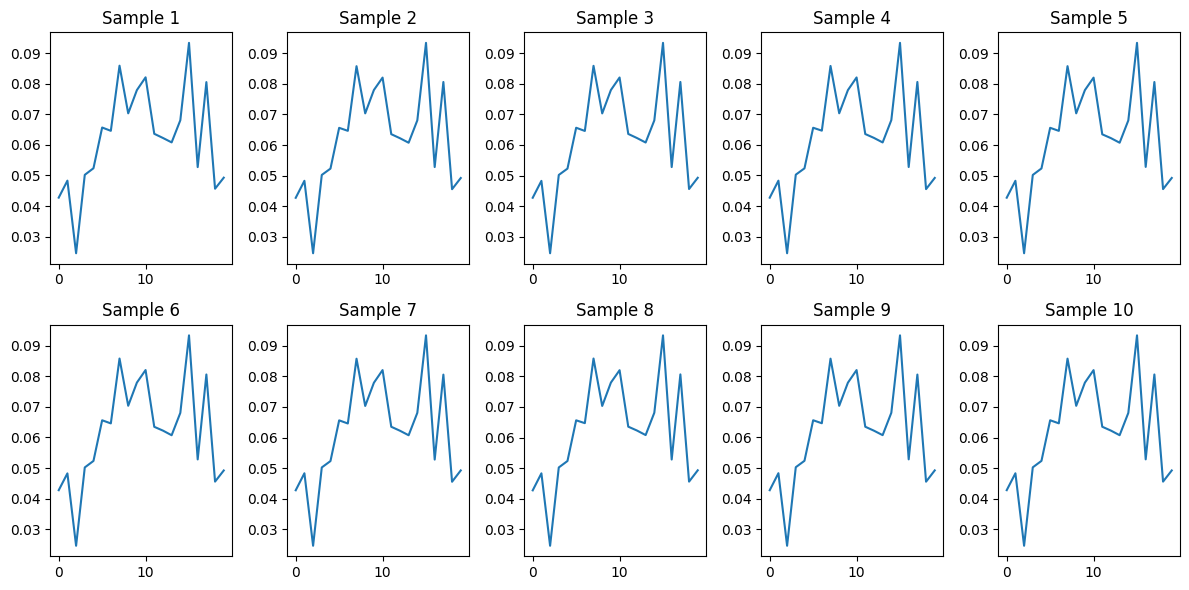

In [ ]:
import matplotlib.pyplot as plt

# Function to generate and plot time series
def generate_and_plot(generator, latent_dim, n_samples=10):
    # Generate random noise
    noise = np.random.normal(0, 1, (n_samples, latent_dim))
    # Generate time series data using the generator
    gen_ts = generator.predict(noise)
    print(gen_ts)

    # Plot the generated time series
    plt.figure(figsize=(12, 6))
    for i in range(n_samples):
        plt.subplot(2, 5, i+1)
        plt.plot(gen_ts[i].reshape(-1))
        plt.title(f"Sample {i+1}")
    plt.tight_layout()
    plt.show()

# Generate and plot 10 samples
generate_and_plot(generator, latent_dim, n_samples=10)


In [ ]:
gen_ts[1]

NameError: name 'gen_ts' is not defined

In [ ]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.layers import Conv1D, LeakyReLU, Dropout, Flatten, Dense, Reshape, Conv1DTranspose
from tensorflow.keras.models import Sequential

# Assuming your dataset is loaded as a NumPy array
# dataset shape is (1008, 20)
# data = np.random.rand(1008, 20)  # Replace this with actual data loading

# Normalize the data
# data = (data - np.min(data)) / (np.max(data) - np.min(data))
# data = data.values

# Reshape data for the discriminator
# data = data.reshape((data.shape[0], data.shape[1], 1))

def build_generator(latent_dim):
    model = Sequential()

    model.add(Dense(128 * 5, activation="relu", input_dim=latent_dim))
    model.add(Reshape((5, 128)))

    model.add(Conv1DTranspose(128, kernel_size=4, strides=2, padding="same"))
    model.add(LeakyReLU(alpha=0.01))

    model.add(Conv1DTranspose(64, kernel_size=4, strides=2, padding="same"))
    model.add(LeakyReLU(alpha=0.01))

    model.add(Conv1D(1, kernel_size=7, activation="tanh", padding="same"))

    return model

latent_dim = 100
generator = build_generator(latent_dim)


# latent_dim = 100
# generator = build_generator(latent_dim)


# latent_dim = 100
# generator = build_generator(latent_dim)

def build_discriminator(input_shape):
    model = Sequential()

    model.add(Conv1D(64, kernel_size=3, strides=2, input_shape=input_shape, padding="same"))
    model.add(LeakyReLU(alpha=0.01))
    model.add(Dropout(0.25))

    model.add(Conv1D(128, kernel_size=3, strides=2, padding="same"))
    model.add(LeakyReLU(alpha=0.01))
    model.add(Dropout(0.25))

    model.add(Conv1D(256, kernel_size=3, strides=2, padding="same"))
    model.add(LeakyReLU(alpha=0.01))
    model.add(Dropout(0.25))

    model.add(Flatten())
    model.add(Dense(1, activation="sigmoid"))

    return model

input_shape = (20, 1)
discriminator = build_discriminator(input_shape)
discriminator.compile(loss="binary_crossentropy", optimizer="adam", metrics=["accuracy"])


# input_shape = (20, 1)
# discriminator = build_discriminator(input_shape)
# discriminator.compile(loss="binary_crossentropy", optimizer="adam", metrics=["accuracy"])


def build_gan(generator, discriminator):
    model = Sequential()
    model.add(generator)
    discriminator.trainable = False
    model.add(discriminator)
    return model

gan = build_gan(generator, discriminator)
gan.compile(loss="binary_crossentropy", optimizer="adam")

tf.keras.utils.plot_model(
    gan,
    show_shapes=True,
    show_dtype=False,
    show_layer_names=True,
)

import matplotlib.pyplot as plt

def train_gan(gan, generator, discriminator, data, latent_dim, epochs=1000, batch_size=64):
    valid = np.ones((batch_size, 1))
    fake = np.zeros((batch_size, 1))

    for epoch in range(epochs):
        # Train Discriminator
        idx = np.random.randint(0, data.shape[0], batch_size)
        real_ts = data[idx]

        noise = np.random.normal(0, 1, (batch_size, latent_dim))
        gen_ts = generator.predict(noise)

        d_loss_real = discriminator.train_on_batch(real_ts, valid)
        d_loss_fake = discriminator.train_on_batch(gen_ts, fake)
        d_loss = 0.5 * np.add(d_loss_real, d_loss_fake)

        # Train Generator
        noise = np.random.normal(0, 1, (batch_size, latent_dim))
        g_loss = gan.train_on_batch(noise, valid)

        if epoch % 1000 == 0:
            print(f"{epoch} [D loss: {d_loss[0]}, acc.: {100*d_loss[1]}] [G loss: {g_loss}]")
            # Optionally, you can save the model or generate samples here

train_gan(gan, generator, discriminator, data, latent_dim, epochs=1000, batch_size=64)



You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model to work.


In [ ]:
tf.keras.utils.plot_model(
    gan,
    show_shapes=True,
    show_dtype=False,
    show_layer_names=True,
)

You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model to work.


In [ ]:
!pip install pydot

2/2 [==============================] - 0s 4ms/step


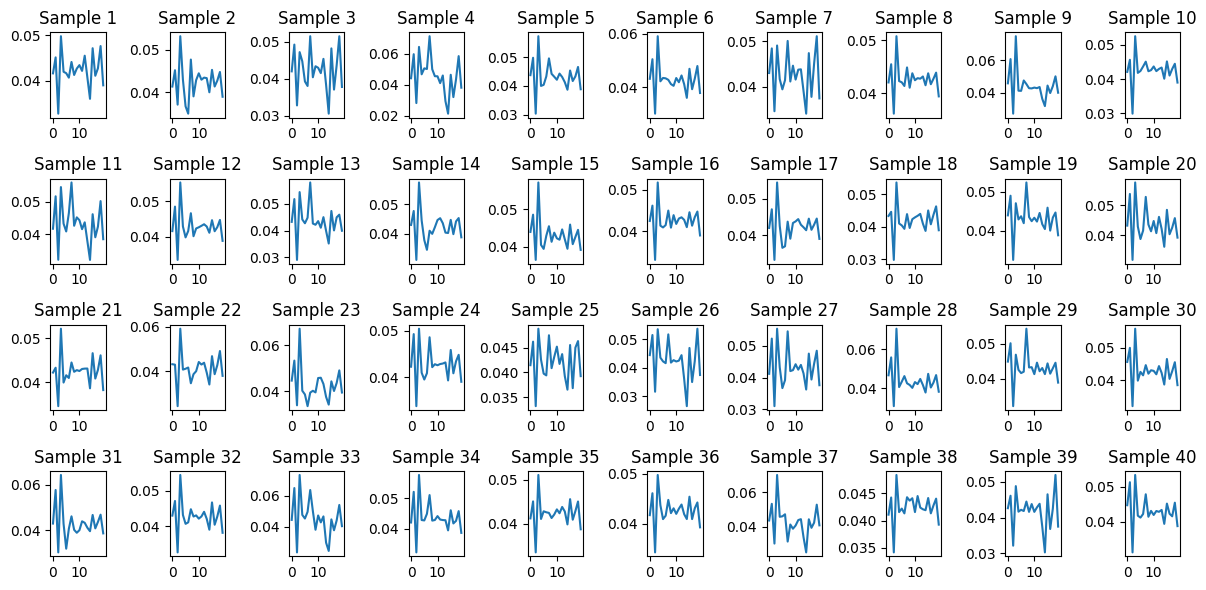

In [ ]:
def generate_and_plot(generator, latent_dim, n_samples=40):
    # Generate random noise
    noise = np.random.normal(0, 1, (n_samples, latent_dim))
    # Generate time series data using the generator
    gen_ts = generator.predict(noise)

    # Plot the generated time series
    plt.figure(figsize=(12, 6))
    for i in range(n_samples):
        plt.subplot(4, 10, i+1)
        plt.plot(gen_ts[i].reshape(-1))
        plt.title(f"Sample {i+1}")
    plt.tight_layout()
    plt.show()
    return(gen_ts)

# Generate and plot 10 samples
x_sim = generate_and_plot(generator, latent_dim, n_samples=40)


In [ ]:
pd.DataFrame(x_sim).to_csv('/content/drive/My Drive/Colab Notebooks/Azure_function_invocation/x_sim_gansimple.csv')

In [ ]:
x_sim = x_sim.reshape([x_sim.shape[0], -1])

In [ ]:

np.shape(x_sim)

(40, 20)